In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from collections import defaultdict
import re
import Levenshtein
from itertools import combinations
from scipy.stats import gmean
import profiler as pf

os.chdir('C:/Users/Admin/Documents/GitHub/Data-Guide')

In [2]:
input_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/transformed_feb_2" 

output_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/analyses_feb_2"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the data
csv_files = {
        "aged_AR" : os.path.join(input_dir, "transformed_aged_AR.csv"),
        # "statement_submission" : os.path.join(input_dir, "statement_submission_report.csv"),
         "integrated_payments" : os.path.join(input_dir, "transformed_integrated_payments.csv"),
        #"billing_statement" : os.path.join(input_dir, "billing_statement_report.csv"),
        # "outstanding_claims" : os.path.join(input_dir, "outstanding_claims_report.csv"),
        # "unresolved_claims" : os.path.join(input_dir, "unresolved_claims_report.csv"),
        #"fee_schedule" : os.path.join(input_dir, "fee_schedule.csv"),
        #"openings" : os.path.join(input_dir,"openings.csv"),
        #"schedule" : os.path.join(input_dir,"schedule.csv"),
        "patient_list" : os.path.join(input_dir, "transformed_patient_details.csv"),
        # "processed_payments": os.path.join(input_dir, "ZR - Credit Card Processed Payments.csv"),
        "transaction_details" : os.path.join(input_dir, "transformed_transaction_details.csv"),
        "charges" : os.path.join(input_dir, "transformed_incurred_charges.csv"),
        # "treatment_tracker" : os.path.join(input_dir, "ZR - Treatment Tracker.csv"),
    }

 # Load datasets
dataframes = {dataset: pd.read_csv(file_path) for dataset, file_path in csv_files.items()}

# Patient Data Only

## Initial processing and simple checks

In [3]:
patients = dataframes["patient_list"]

patients['surviving'] = (patients['Status'] == 'ACTIVE') | (pd.to_datetime(patients['Last Visit']) > (pd.Timestamp.today() - pd.DateOffset(years=1)))

In [4]:
patients['surviving'].value_counts()

surviving
True     941
False    901
Name: count, dtype: int64

In [5]:
# Find those who only have one visit

patients['lone_vist'] = patients['Last Visit'] == patients['First Visit']
patients['lone_vist'].value_counts()

lone_vist
False    1618
True      224
Name: count, dtype: int64

In [6]:
patients['lifespan'] = patients.apply(lambda row: max((pd.Timestamp.today() - pd.to_datetime(row['First Visit'])).days, 
                                                      (pd.to_datetime(row['Next Appointment Date']) - pd.to_datetime(row['First Visit'])).days) 
                                      if row['surviving'] else 
                                      (pd.to_datetime(row['Last Visit']) - pd.to_datetime(row['First Visit'])).days, axis=1)

In [7]:
temporal = pf.TemporalAnalyzer(patients, output_dir)
plotters = pf.DataProfilerPlots(patients)

In [8]:
numeric = pf.NumericProfiler(patients['lifespan'])
numeric.profile()

{'distinct_values': 757,
 'statistics': {'count': 1486.0,
  'mean': 499.03,
  'std': 443.46,
  'min': 0.0,
  '1%': 0.0,
  '5%': 0.0,
  '33%': 187.0,
  '50%': 387.0,
  '66%': 627.6,
  '95%': 1346.75,
  '99%': 1590.6,
  'max': 1686.0},
 'skewness': np.float64(0.7),
 'kurtosis': np.float64(-0.55),
 'most_common': {0.0: 143, 182.0: 21, 1.0: 17, 189.0: 14},
 'least_common': {1295.0: 1, 252.0: 1, 75.0: 1, 652.0: 1},
 'outliers': [],
 'count_negative': np.int64(0),
 'count_zero': np.int64(143),
 'avg_nonzero': np.float64(552.1675353685778),
 'count_blank': np.int64(356)}

In [9]:
plotters.histogram('lifespan', f"{output_dir}/lifespan_hist.png")
plotters.kde_plot('lifespan', f"{output_dir}/lifespan_kde.png")
plotters.box_plot('lifespan', f"{output_dir}/lifespan_box.png")

In [10]:
patients['Cleaned Carrier'].value_counts().head(30)

Cleaned Carrier
Delta Dental                                   350
Blue Cross Blue Shield                         231
MetLife                                        223
Aetna                                          146
Guardian                                       138
CIGNA Global Health                            131
United Healthcare Dental                        98
Humana                                          24
Sun Life Financial (PO Box 2940 Clinton IA)     22
Principal Financial Group                       17
Unum (Administered by Starmount)                10
Principal Life Insurance Company                 9
UMR- Wausau /UHIS                                7
Guardian Individual Plan                         6
Ameritas Life Insurance Corp                     6
BEAM Dental Insurance                            4
US Health Group                                  3
GEHA                                             3
Anthem Blue Cross CA                             3
Allied Benefit 

In [11]:
carriers = ['Delta Dental', 'Blue Cross Blue Shield', 'MetLife', 'Aetna', 'Guardian','CIGNA Global Health', 'United Healthcare Dental', 'Humana', 'Sun Life Financial (PO Box 2940 Clinton IA)', 'Principal Financial Group', 'Unum (Administered by Starmount)']

In [12]:
patients['carrier'] = patients['Cleaned Carrier'].apply(lambda x: x if x in carriers else 'OTHER')
patients['carrier'].value_counts()

carrier
OTHER                                          452
Delta Dental                                   350
Blue Cross Blue Shield                         231
MetLife                                        223
Aetna                                          146
Guardian                                       138
CIGNA Global Health                            131
United Healthcare Dental                        98
Humana                                          24
Sun Life Financial (PO Box 2940 Clinton IA)     22
Principal Financial Group                       17
Unum (Administered by Starmount)                10
Name: count, dtype: int64

In [13]:
patients['ZIP'] = patients['ZIP Code'].apply(lambda x: x if x in ['60640', '60613', '60625', '60618'] else 'OTHER')
patients['ZIP'].value_counts()

ZIP
60640    1114
OTHER     297
60613     184
60625     166
60618      81
Name: count, dtype: int64

In [14]:
patients['DCS'] = patients['Pat. Prim. Plan'].str.contains('DCS')
patients['DNU'] = patients['Pat. Prim. Plan'].str.contains('DNU')

In [15]:
patients.loc[(patients['lifespan'].isna()) & (patients['Status'].isin(['ACTIVE', 'INACTIVE'])) & (~patients['First Visit'].isna())].drop(columns=['Patient', 'Primary Guarantor', 'Primary Contact', 'Last Name', 'Chart Number', 'Ascend Patient ID', 'Date Of Birth', 'Phone', 'Email', 'Address']).head(30)

,Empty,Status,First Visit,Last Visit,Last Procedure Date,Next Appointment Date,Discount Plan,Pat. Prim. Fee Schedule,Pat. Prim. Carrier,Pat. Prim. Plan,...,plan_name,plan_name_cruft,university_or_college_plan,Simplest_Equivalent_Plan,plan_name_diff,surviving,lone_vist,lifespan,carrier,ZIP
67,NaN,INACTIVE,2021-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60625
355,NaN,INACTIVE,2020-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,OTHER
404,NaN,INACTIVE,2023-02-22,NaN,NaN,NaN,NaN,Careington Care Platinum PPO 2025,MetLife,Johann,...,Johann,NaN,False,johann,NaN,False,False,NaN,MetLife,OTHER
670,NaN,INACTIVE,2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60640
757,NaN,INACTIVE,2021-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60640
818,NaN,INACTIVE,2021-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60640
1819,NaN,INACTIVE,2021-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,OTHER


In [16]:
patients.loc[(patients['lifespan'].isna()) & (patients['Status'].isin(['ACTIVE', 'INACTIVE'])) & (~patients['First Visit'].isna()), 'lifespan'] = 0

In [17]:
prediction_columns = ['surviving', 'lone_vist', 'lifespan', 'Discount Plan', 'Pat. Prim. Fee Schedule', 'carrier', 'ZIP', 'student', 'patientAge', 'DCS', 'DNU']

## Survival Analyses

In [18]:
return_df = patients.loc[(patients['First Visit'] < '2024-02-01') & (patients['Status'].isin(['ACTIVE', 'INACTIVE'])) & (~patients['First Visit'].isna()), prediction_columns].copy()
survival_df = patients.loc[(patients['Status'].isin(['ACTIVE', 'INACTIVE']) & (~patients['First Visit'].isna())), prediction_columns].copy()

In [19]:
return_df

,surviving,lone_vist,lifespan,Discount Plan,Pat. Prim. Fee Schedule,carrier,ZIP,student,patientAge,DCS,DNU
3,True,False,1057.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,43.0,False,False
4,True,False,791.0,NaN,Delta Dental Premier,Delta Dental,60625,Non-Student,49.0,True,False
5,False,False,64.0,NaN,Careington Care Platinum PPO 2025,United Healthcare Dental,60640,Non-Student,46.0,False,True
6,False,False,41.0,NaN,Careington Care Platinum PPO 2025,United Healthcare Dental,60640,Non-Student,47.0,False,False
7,True,False,987.0,NaN,Careington Care Platinum PPO 2025,MetLife,60640,Non-Student,31.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1834,False,True,0.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,45.0,False,True
1835,True,False,1030.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,28.0,False,False
1836,False,False,28.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60613,Non-Student,33.0,False,False
1838,True,False,742.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,40.0,False,False


In [20]:
survival_df

,surviving,lone_vist,lifespan,Discount Plan,Pat. Prim. Fee Schedule,carrier,ZIP,student,patientAge,DCS,DNU
0,True,False,246.0,NaN,Careington Care Platinum PPO 2025,Aetna,60625,Non-Student,44.0,True,True
1,True,False,151.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,39.0,False,False
3,True,False,1057.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,43.0,False,False
4,True,False,791.0,NaN,Delta Dental Premier,Delta Dental,60625,Non-Student,49.0,True,False
5,False,False,64.0,NaN,Careington Care Platinum PPO 2025,United Healthcare Dental,60640,Non-Student,46.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...
1835,True,False,1030.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,28.0,False,False
1836,False,False,28.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60613,Non-Student,33.0,False,False
1838,True,False,742.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,40.0,False,False
1839,True,False,180.0,NaN,Delta Dental TOA 2025 STATE OF IL-QCDP,Delta Dental,60640,Non-Student,60.0,False,False


In [21]:
numeric = pf.NumericProfiler(survival_df['lifespan'])
numeric.profile()

{'distinct_values': 757,
 'statistics': {'count': 1480.0,
  'mean': 499.61,
  'std': 443.44,
  'min': 0.0,
  '1%': 0.0,
  '5%': 0.0,
  '33%': 187.0,
  '50%': 387.5,
  '66%': 633.0,
  '95%': 1347.0,
  '99%': 1590.84,
  'max': 1686.0},
 'skewness': np.float64(0.7),
 'kurtosis': np.float64(-0.55),
 'most_common': {0.0: 145, 182.0: 21, 1.0: 16, 7.0: 13},
 'least_common': {744.0: 1, 1578.0: 1, 448.0: 1, 1319.0: 1},
 'outliers': [],
 'count_negative': np.int64(0),
 'count_zero': np.int64(145),
 'avg_nonzero': np.float64(553.8749063670411),
 'count_blank': np.int64(0)}

In [22]:
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter

<Axes: xlabel='timeline'>

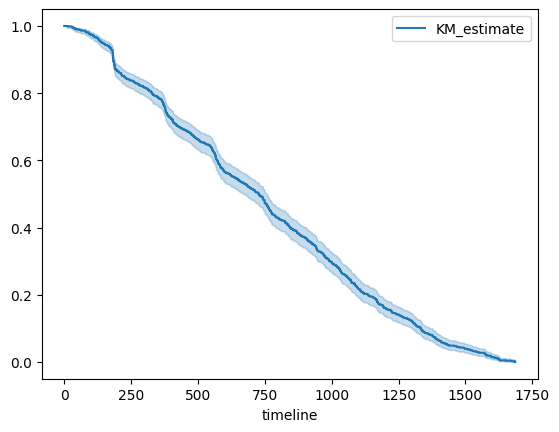

In [23]:
# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(survival_df['lifespan'], event_observed=survival_df['surviving'])

# Plot survival curve
kmf.plot_survival_function()

In [24]:
s_df = pd.get_dummies(survival_df, drop_first=True).drop(columns=['lone_vist'])
s_df

,surviving,lifespan,patientAge,Discount Plan_Employee Dental Plan,Discount Plan_Wellness - I,Pat. Prim. Fee Schedule_AlwaysCare,Pat. Prim. Fee Schedule_CIGNA 2022 Z219,Pat. Prim. Fee Schedule_Careington Care Platinum PPO 2025,Pat. Prim. Fee Schedule_Delta Dental Premier,Pat. Prim. Fee Schedule_Delta Dental TOA 2025 STATE OF IL-QCDP,...,carrier_Sun Life Financial (PO Box 2940 Clinton IA),carrier_United Healthcare Dental,carrier_Unum (Administered by Starmount),ZIP_60618,ZIP_60625,ZIP_60640,ZIP_OTHER,student_Student,DCS_True,DNU_True
0,True,246.0,44.0,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,True
1,True,151.0,39.0,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,True,1057.0,43.0,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,True,791.0,49.0,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
5,False,64.0,46.0,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,True,1030.0,28.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1836,False,28.0,33.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1838,True,742.0,40.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1839,True,180.0,60.0,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column Discount Plan_Employee Dental Plan have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['surviving'].astype(bool)
>>> print(df.loc[events, 'Discount Plan_Employee Dental Plan'].var())
>>> print(df.loc[~events, 'Discount Plan_Employee Dental Plan'].var())

A very low variance means that the column Discount Plan_Employee Dental Plan completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

<lifelines.CoxPHFitter: fitted with 1480 total observations, 544 right-censored observations>
             duration col = 'lifespan'
                event col = 'surviving'
      baseline estimation = breslow
   number of observations = 1480
number of events observed = 936
   partial log-likelihood = -5519.20
         time fit was run = 2025-02-13 06:40:13 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
patientAge                                                      -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
Discount Plan_Employee Dental Plan                              -0.04      0.96      0.60           -1.22            1.13                0.30                3.10
Discount Plan_Wellness - I                                       0.09      1.09      0.22           -0.34            0.51                0.71                1.66
Pat. Prim. Fee Schedule_AlwaysCare                              11.90  1.47e+05    635.50        -1233.66         1257.46                0.00                 inf
Pat. Prim. Fee Schedule_CIGNA 2022 Z219                         -0.40      0.67      0.59           -1.56            0.75                0.21                2.12
Pat. Prim. Fee Schedule_Careington Care Platinum PPO 2025        0.12      1.12      0.17           -0.22            0.46                0.80                1.58
Pat. Prim. Fee Schedule_Delta Dental Premier                    -0.41      0.66      0.55           -1.49            0.68                0.22                1.97
Pat. Prim. Fee Schedule_Delta Dental TOA 2025 STATE OF IL-QCDP  -0.56      0.57      0.61           -1.75            0.64                0.17                1.89
Pat. Prim. Fee Schedule_Dental Health Alliance                  -0.07      0.93      0.53           -1.11            0.97                0.33                2.63
carrier_Blue Cross Blue Shield                                   0.05      1.05      0.14           -0.22            0.32                0.80                1.37
carrier_CIGNA Global Health                                      0.42      1.52      0.61           -0.78            1.62                0.46                5.05
carrier_Delta Dental                                             0.50      1.65      0.58           -0.62            1.63                0.54                5.11
carrier_Guardian                                                -0.09      0.91      0.16           -0.40            0.22                0.67                1.25
carrier_Humana                                                   0.35      1.42      0.28           -0.19            0.89                0.82                2.44
carrier_MetLife                                                 -0.08      0.92      0.14           -0.36            0.19                0.70                1.21
carrier_OTHER                                                   -0.21      0.81      0.21           -0.62            0.19                0.54                1.21
carrier_Principal Financial Group                               -0.20      0.82      0.49           -1.16            0.77                0.31                2.16
carrier_Sun Life Financial (PO Box 2940 Clinton IA)              0.58      1.78      0.59           -0.57            1.73                0.57                5.62
carrier_United Healthcare Dental                                -0.25      0.78      0.18           -0.59            0.10                0.55                1.11
carrier_Unum (Administered by Starmount)                       -12.05      0.00    635.50        -1257.61         1233.51                0.00                 inf
ZIP_60618                                                       -0.0

<Axes: xlabel='log(HR) (95% CI)'>

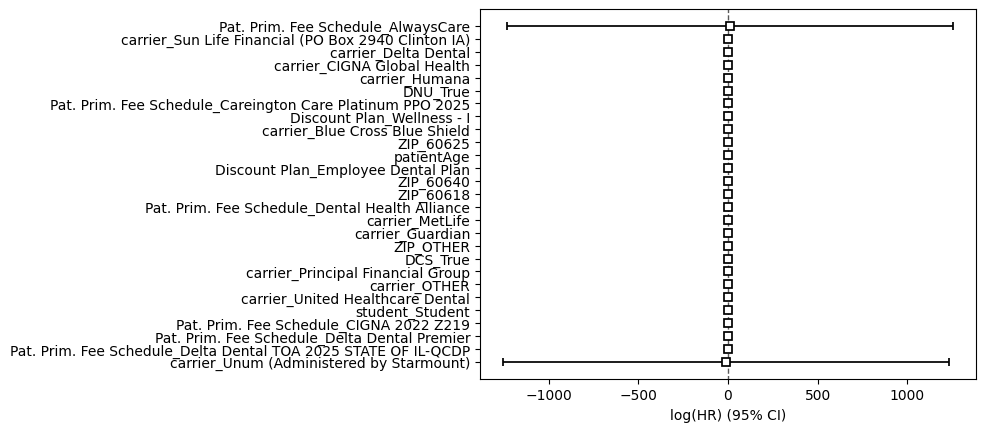

In [25]:
# Fit Cox model
cph = CoxPHFitter()
cph.fit(s_df, duration_col='lifespan', event_col='surviving')

# Print results and plot
cph.print_summary()
cph.plot()

<lifelines.CoxPHFitter: fitted with 1480 total observations, 544 right-censored observations>
             duration col = 'lifespan'
                event col = 'surviving'
      baseline estimation = breslow
   number of observations = 1480
number of events observed = 936
   partial log-likelihood = -5528.58
         time fit was run = 2025-02-13 06:40:14 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
patientAge     -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
DCS_True       -0.16      0.85      0.07           -0.29           -0.02                0.75                0.98
DNU_True        0.17      1.19      0.08            0.02            0.32                1.02                1.38
carrier_Humana  0.42      1.52      0.25           -0.07            0.91                0.93                2.47

                cmp to     z      p  -log2(p)
covariate                                    
patientAge        0.00 -5.22 <0.005     22.44
DCS_True          0.00 -2.30   0.02      5.54
DNU_True          0.00  2.16   0.03      5.03
carrier_Humana    0.00  1.69   0.09      3.45
---
Concordance = 0.57
Partial AIC = 11065.16
log-likelihood ratio test = 39.41 on 4 df
-log2(p) of ll-ratio test = 24.06

<Axes: xlabel='log(HR) (95% CI)'>

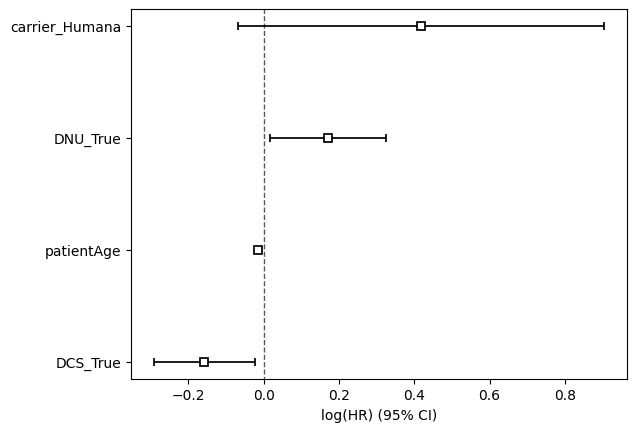

In [26]:
# Fit Cox model
cph = CoxPHFitter()
cph.fit(s_df.loc[:,['surviving','lifespan', 'patientAge', 'DCS_True', 'DNU_True', 'carrier_Humana']], duration_col='lifespan', event_col='surviving')

# Print results and plot
cph.print_summary()
cph.plot()

## Survival Curves

In [27]:
s_df2 = survival_df.copy()

# Convert categorical predictors to strings for stratification
columns_to_convert = ['Discount Plan', 'carrier', 'Pat. Prim. Fee Schedule', 'ZIP', 'student', 'DCS', 'DNU']
s_df2[columns_to_convert] = s_df2[columns_to_convert].apply(lambda x: x.astype(str))

# Create age bins for Kaplan-Meier stratification
s_df2['Age Group'] = pd.cut(s_df2['patientAge'], bins=[18, 30, 50, 80], labels=["18-30", "30-50", "50+"])

In [28]:
def plot_km_survival(df, time_col, event_col, group_col):
    """
    Plots Kaplan-Meier survival curves stratified by a categorical column.

    Args:
        df (pd.DataFrame): The dataframe containing survival data.
        time_col (str): The column representing duration/time.
        event_col (str): The column representing event occurrence (1 = event, 0 = censored).
        group_col (str): The categorical column to stratify by.
    
    Returns:
        None (Displays the survival plot)
    """
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    for category in df[group_col].dropna().unique():
        subset = df[df[group_col] == category]
        kmf.fit(subset[time_col], event_observed=subset[event_col], label=str(category))
        kmf.plot_survival_function()

    plt.title(f"Kaplan-Meier Survival Curve by {group_col}")
    plt.xlabel("Time (Days)")
    plt.ylabel("Survival Probability")
    plt.legend(title=group_col)
    plt.grid(True)
    plt.show()

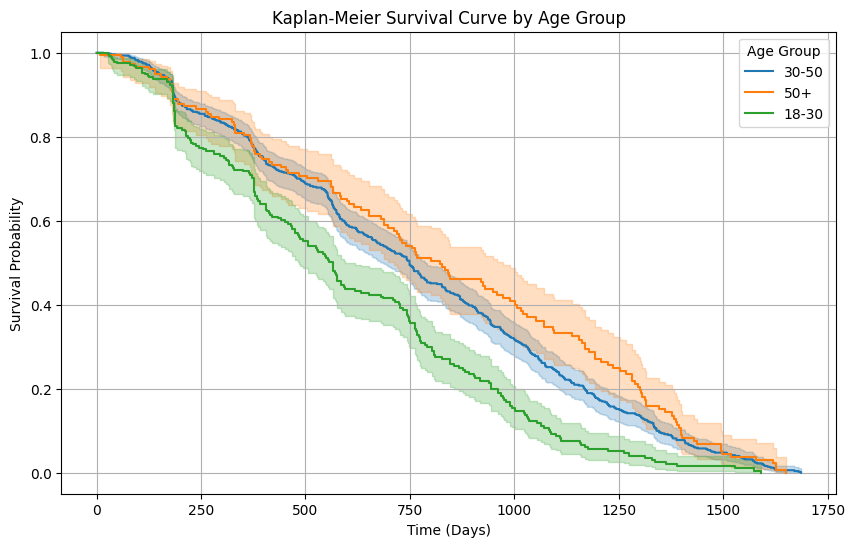

In [29]:
plot_km_survival(s_df2,'lifespan', 'surviving', 'Age Group')

In [30]:
carriers = ['Delta Dental', 'Blue Cross Blue Shield', 'MetLife']
s_df2['carrier'] = s_df2['carrier'].apply(lambda x: x if x in carriers else 'OTHER')
s_df2['carrier'].value_counts()

carrier
OTHER                     770
Delta Dental              306
Blue Cross Blue Shield    203
MetLife                   201
Name: count, dtype: int64

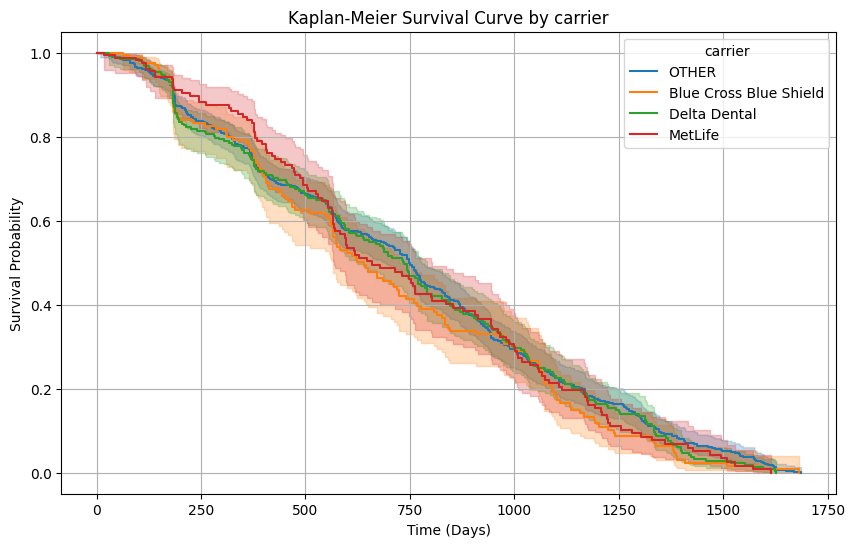

In [31]:
# columns_to_convert = ['Discount Plan', 'carrier', 'Pat. Prim. Fee Schedule', 'ZIP', 'student', 'DCS', 'DNU']
plot_km_survival(s_df2,'lifespan', 'surviving', 'carrier')

In [32]:
s_df2['Pat. Prim. Fee Schedule'].value_counts()

Pat. Prim. Fee Schedule
Careington Care Platinum PPO 2025         764
Delta Dental Premier                      291
nan                                       200
CIGNA 2022 Z219                           110
 Juniper Office Fees                       64
Dental Health Alliance                     26
Delta Dental TOA 2025 STATE OF IL-QCDP     18
AlwaysCare                                  7
Name: count, dtype: int64

In [33]:
fee_schedules = ['Careington Care Platinum PPO 2025', 'Delta Dental Premier', 'CIGNA 2022 Z219', ' Juniper Office Fees']
s_df2['fee_schedule'] = s_df2['Pat. Prim. Fee Schedule'].apply(lambda x: x if x in fee_schedules else 'OTHER or None')
s_df2['fee_schedule'].value_counts()

fee_schedule
Careington Care Platinum PPO 2025    764
Delta Dental Premier                 291
OTHER or None                        251
CIGNA 2022 Z219                      110
 Juniper Office Fees                  64
Name: count, dtype: int64

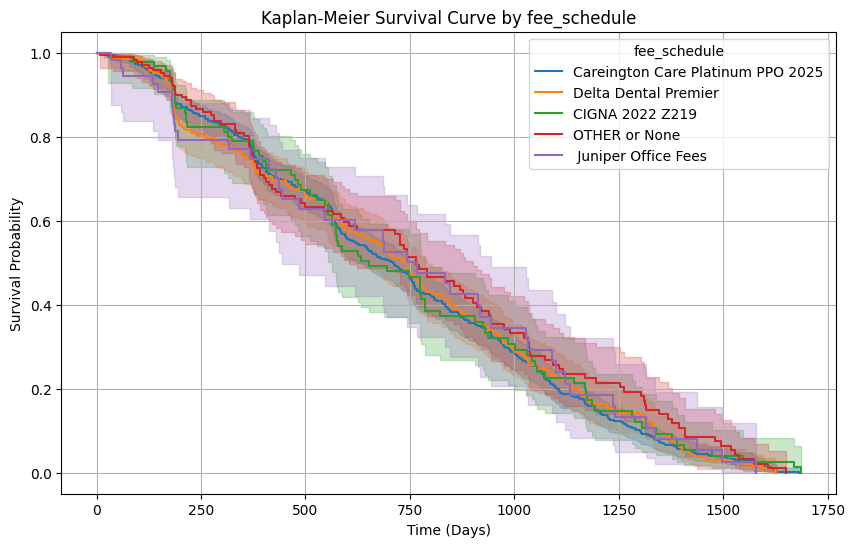

In [34]:
# columns_to_convert = ['Discount Plan', 'carrier', 'Pat. Prim. Fee Schedule', 'ZIP', 'student', 'DCS', 'DNU']
plot_km_survival(s_df2,'lifespan', 'surviving', 'fee_schedule')

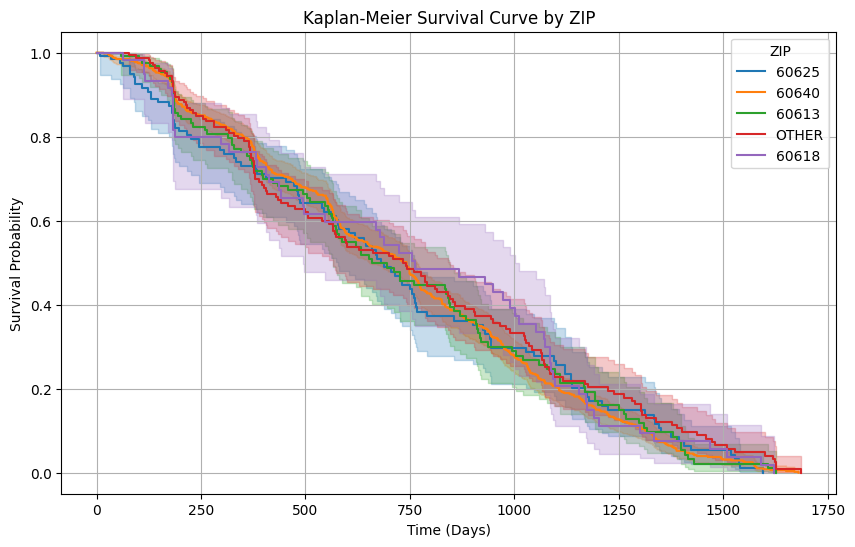

In [35]:
plot_km_survival(s_df2,'lifespan', 'surviving', 'ZIP')

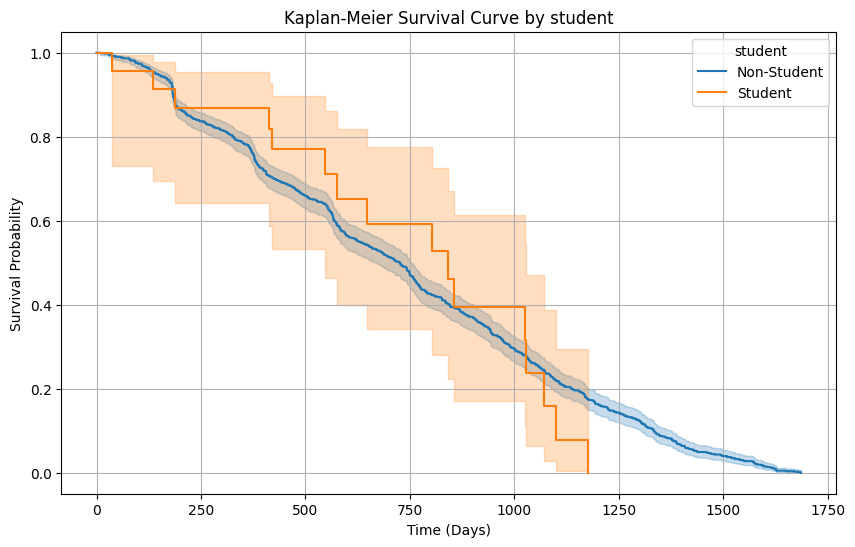

In [36]:
plot_km_survival(s_df2,'lifespan', 'surviving', 'student')

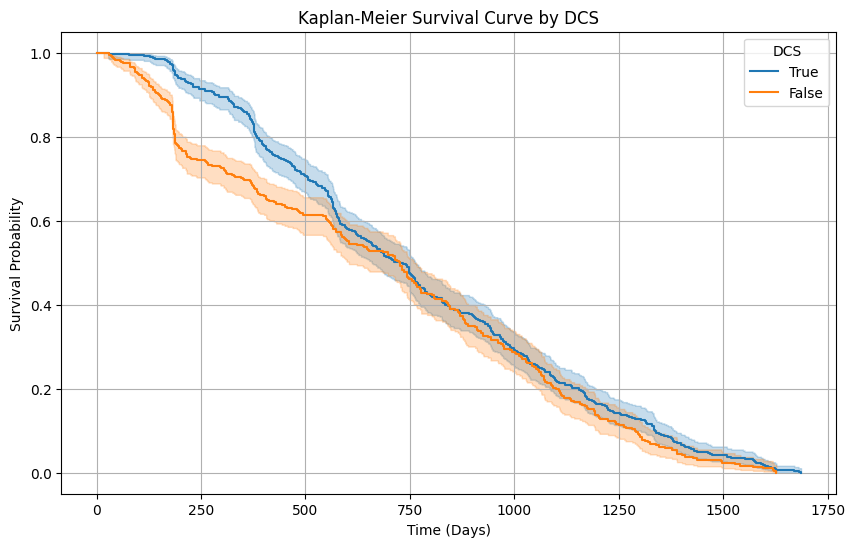

In [37]:
plot_km_survival(s_df2.loc[s_df2['DCS'] != 'nan'],'lifespan', 'surviving', 'DCS')

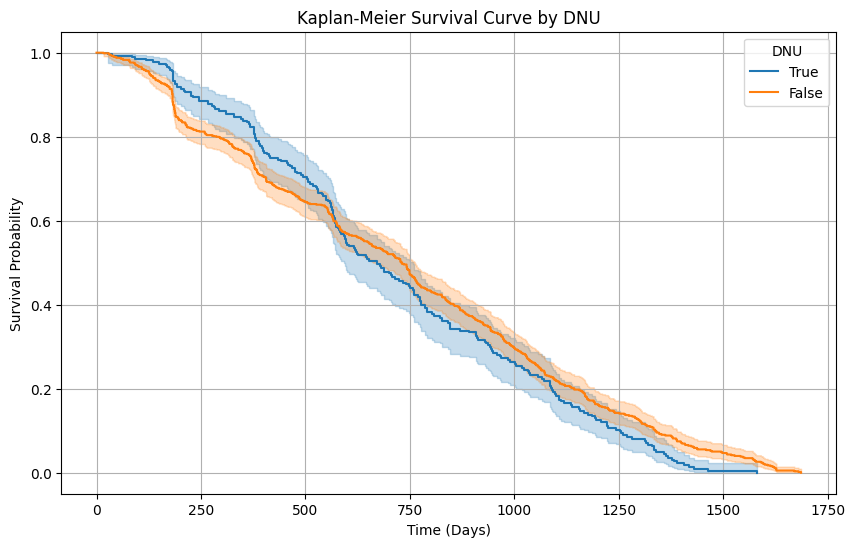

In [38]:
plot_km_survival(s_df2.loc[s_df2['DNU'] != 'nan'],'lifespan', 'surviving', 'DNU')

## Transaction & Charges processing

In [39]:
transactions = dataframes["transaction_details"].copy()
charges = dataframes["charges"].copy()

In [40]:
transactions

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
0,10/27/2019,"Gabriel, Rami",14000002286456,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,06/21/2020,"Barrios, James",14000002286515,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,47.2,0.0,...,False,False,False,False,False,False,False,False,False,False
2,10/08/2020,"Greene, David E",14000002286843,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,10/08/2020,"Koenig, Cody",14000002286781,CK5152H,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,10/20/2020,"Reiman, Stephanie M",14000002286454,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52450,02/04/2025,"Sullivan, Shannon",14000007527403,Not Available,Procedures,D2740,Full Porcelain/Ceramic Crown,Th30,1680.0,0.0,...,False,False,False,False,False,False,False,False,False,False
52451,02/04/2025,"Sullivan, Shannon",14000007527403,Not Available,Procedures,D2950,Core Buildup w/ Any Pins,Th30,404.0,0.0,...,False,False,False,False,False,False,False,False,False,False
52452,02/04/2025,"Worden, Mitchell",14000004469269,Not Available,Credit Adjustments,D2392,Posterior Resin Composite 2s,NaN,0.0,-299.0,...,False,False,False,False,False,True,False,False,False,False
52453,02/04/2025,"Worden, Mitchell",14000004469269,Not Available,Insurance Payments,D2392,Posterior Resin Composite 2s,NaN,0.0,-35.2,...,False,False,False,False,False,True,False,False,False,False


In [41]:
charges

,Ascend Patient ID,Patient,Date (Modified),Card Holder,Card Type,Transaction ID,Card Source,Reference Number,Transaction Type,Amount,sort_key,Days Between,Rolling Days Between,Running Total
0,14000002286402,"Intagliata, Emily",2022-11-01,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-364.0,0,NaN,0.0,-364.0
1,14000002286402,"Intagliata, Emily",2024-01-02,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-197.0,0,131.0,0.0,-80.5
2,14000002286402,"Intagliata, Emily",2024-07-05,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-239.0,0,169.0,0.0,-122.5
3,14000002286402,"Intagliata, Emily",2024-07-25,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-738.0,0,8.0,0.0,-621.5
4,14000002286402,"Intagliata, Emily",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-280.0,0,111.0,0.0,-163.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,14000008880368,"Azoulay Grinspan, Daniel",2025-02-04,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-474.0,0,NaN,0.0,-474.0
4834,14000008899060,"Kolasa, Mark",2025-01-30,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-974.0,0,NaN,0.0,-974.0
4835,14000008899060,"Kolasa, Mark",2025-02-04,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-193.0,0,5.0,0.0,-193.0
4836,14000008909950,"Lurbur, Hadassah",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-474.0,0,NaN,0.0,-474.0


In [42]:
charges['Amount'] = charges['Amount']*-1
charges['Date'] = pd.to_datetime(charges['Date (Modified)'])
charges = charges[charges['Amount'] > 0]

In [43]:
charges

,Ascend Patient ID,Patient,Date (Modified),Card Holder,Card Type,Transaction ID,Card Source,Reference Number,Transaction Type,Amount,sort_key,Days Between,Rolling Days Between,Running Total,Date
0,14000002286402,"Intagliata, Emily",2022-11-01,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,364.0,0,NaN,0.0,-364.0,2022-11-01
1,14000002286402,"Intagliata, Emily",2024-01-02,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,197.0,0,131.0,0.0,-80.5,2024-01-02
2,14000002286402,"Intagliata, Emily",2024-07-05,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,239.0,0,169.0,0.0,-122.5,2024-07-05
3,14000002286402,"Intagliata, Emily",2024-07-25,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,738.0,0,8.0,0.0,-621.5,2024-07-25
4,14000002286402,"Intagliata, Emily",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,280.0,0,111.0,0.0,-163.5,2025-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,14000008880368,"Azoulay Grinspan, Daniel",2025-02-04,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,474.0,0,NaN,0.0,-474.0,2025-02-04
4834,14000008899060,"Kolasa, Mark",2025-01-30,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,974.0,0,NaN,0.0,-974.0,2025-01-30
4835,14000008899060,"Kolasa, Mark",2025-02-04,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,193.0,0,5.0,0.0,-193.0,2025-02-04
4836,14000008909950,"Lurbur, Hadassah",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,474.0,0,NaN,0.0,-474.0,2025-02-03


In [113]:
charge_data = charges.groupby('Ascend Patient ID').agg({
    "Amount": [
        ("Total Charges", lambda x: x.sum()), 
        ("Average Charge", lambda x: x.mean().round()), 
        ("Max Charge", lambda x: x.max())
    ],
    "Date": [
        ("Number of Charges", lambda x: x.count()), 
        ("First Charge Date", lambda x: x.min()), 
        ("Last Charge Date", lambda x: x.max()), 
        ("Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    charges_per_year=lambda d: ( # Change to # Semiannual Charges
        (d[("Date", "Number of Charges")] * 365 / d[("Date", "Timespan")])
        .where(d[("Date", "Timespan")] > 365, d[("Date", "Number of Charges")])  # Fix for division by zero 
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

charge_data

Amount                                        Date  \
                  Total Charges Average Charge Max Charge Number of Charges   
Ascend Patient ID                                                             
14000002286402           1818.0          364.0      738.0                 5   
14000002286403            561.0          280.0      364.0                 2   
14000002286404           3081.0          440.0     1399.0                 7   
14000002286406           6187.0          562.0     3054.0                11   
14000002286407            561.0          280.0      364.0                 2   
...                         ...            ...        ...               ...   
14000008880356            448.0          448.0      448.0                 1   
14000008880368            474.0          474.0      474.0                 1   
14000008899060           1167.0          584.0      974.0                 2   
14000008909950            474.0          474.0      474.0                 1   
14000008928017            500.0          500.0      500.0                 1   

                                                              charges_per_year  
                  First Charge Date Last Charge Date Timespan                   
Ascend Patient ID                                                               
14000002286402           2022-11-01       2025-02-03      825                2  
14000002286403           2022-11-17       2023-08-24      280                2  
14000002286404           2022-08-25       2024-11-14      812                3  
14000002286406           2023-01-03       2025-01-10      738                5  
14000002286407           2023-03-16       2023-09-19      187                2  
...                             ...              ...      ...              ...  
14000008880356           2025-01-29       2025-01-29        0                1  
14000008880368           2025-02-04       2025-02-04        0                1  
14000008899060           2025-01-30       2025-02-04        5                2  
14000008909950           2025-02-03       2025-02-03        0                1  
14000008928017           2025-02-04       2025-02-04        0                1  

[1238 rows x 8 columns]

In [46]:
charge_plotters = pf.DataProfilerPlots(charge_data)

In [114]:
for col in charge_data.select_dtypes(exclude=['datetime64[ns]']).columns:
    print(f"Numeric Profiling for {col}")
    print(pf.NumericProfiler(charge_data[col]).profile())
    print("\n")
    charge_plotters.histogram(col, f"{output_dir}/{col}_hist.png")

Numeric Profiling for ('Amount', 'Total Charges')
{'distinct_values': 814, 'statistics': {'count': 1238.0, 'mean': 1738.62, 'std': 1554.84, 'min': 95.0, '1%': 197.0, '5%': 341.0, '33%': 895.42, '50%': 1319.0, '66%': 1841.42, '95%': 4621.55, '99%': 7678.29, 'max': 16174.0}, 'skewness': np.float64(2.65), 'kurtosis': np.float64(12.23), 'most_common': {430.0: 67, 627.0: 22, 364.0: 21, 197.0: 17}, 'least_common': {974.0: 1, 1687.0: 1, 1167.0: 1, 1798.0: 1}, 'outliers': [6187.0, 8144.0, 11267.0, 5419.0, 4809.0, 5638.0, 5368.0, 5829.0, 5357.0, 5571.0, 5202.0, 16174.0, 5829.1, 4889.0, 5673.0, 6057.0, 7783.0, 9164.0, 12710.0, 8130.0, 7500.0, 9839.0, 5485.0, 6800.0, 5878.0, 4995.0, 6236.0, 5144.0, 5277.0, 5831.0, 6918.0, 9633.0, 6440.0, 5433.0, 5342.0, 5725.0, 9135.0, 5522.0, 5017.0, 5904.0, 8237.0, 8363.0, 6117.0, 5788.0, 5659.0, 7090.0, 5080.0, 7175.0, 7153.0, 6164.0, 5151.0, 6112.0, 5160.0, 5602.25, 6156.25, 9008.0, 6814.0], 'count_negative': np.int64(0), 'count_zero': np.int64(0), 'avg_nonze

KeyError: ('charges_per_year', '')

In [52]:
transactions['Date'] = pd.to_datetime(transactions['Date'])

procedures = transactions.loc[transactions['Category'] == 'Procedures'].copy()
insurance_payments = transactions.loc[transactions['Category'] == 'Insurance Payments'].copy()
guarantor_payments = transactions.loc[transactions['Category'] == 'Guarantor Payments'].copy()

In [53]:
procedures

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
5,2020-10-22,"Giles-spencer, Diane",14000002286826,Not Available,Procedures,D0180,Periodontal Evaluation,Mouth,134.0,0.0,...,False,False,False,False,False,False,False,False,False,False
6,2020-10-22,"Giles-spencer, Diane",14000002286826,Not Available,Procedures,D0210,Intraoral – comprehensive series of radiograph...,NaN,180.0,0.0,...,False,False,False,False,False,False,False,False,True,False
13,2021-01-05,"Wright, Ernest",14000002286528,Not Available,Procedures,D0180,Periodontal Evaluation,Mouth,134.0,0.0,...,False,False,False,False,False,False,False,False,False,False
14,2021-01-05,"Wright, Ernest",14000002286528,Not Available,Procedures,D0210,Intraoral – comprehensive series of radiograph...,NaN,180.0,0.0,...,False,False,False,False,False,False,False,False,True,False
15,2021-01-05,"Wright, Ernest",14000002286528,Not Available,Procedures,D1110,Prophylaxis - Adult,NaN,125.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52440,2025-02-04,"Shimer, Zachary",14000007848576,Not Available,Procedures,D1110,Prophylaxis - Adult,Mouth,138.0,0.0,...,False,False,False,False,False,False,False,False,False,False
52441,2025-02-04,"Shimer, Zachary",14000007848576,Not Available,Procedures,D1206,Topical Applic Fluoride Varnish,Mouth,62.0,0.0,...,False,False,False,False,False,False,False,False,False,False
52449,2025-02-04,"Sullivan, Shannon",14000007527403,Not Available,Procedures,D0350,2D Oral/Facial Photo Images,Mouth,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
52450,2025-02-04,"Sullivan, Shannon",14000007527403,Not Available,Procedures,D2740,Full Porcelain/Ceramic Crown,Th30,1680.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [72]:
proc_words = ['evaluation', 'intraoral', 'periapical', 'prophylaxis', 'bitewing', 'resin', 'composite', 'images', 'posterior']
proc_types = {'Th7, Th8, Th9, Th10': "Th7-10", 'Th23, Th24, Th25, Th26': 'Th23-26', 'Mouth ': 'Mouth'}
# Take 'Th7, Th8, Th9, Th10', 'Th23, Th24, Th25, Th26', 'Mouth', and 'Other'
# 'Proc Treatment Area'
# Top 5 and Other
# 'Proc. Description'

In [85]:
proc_data = procedures.groupby('Ascend Patient ID').agg({
    "Charges": [
        ("Total Charges", lambda x: x.sum()), 
        ("Average Charge", lambda x: x.mean().round()), 
        ("Max Charge", lambda x: x.max())
    ],
    "Date": [
        ("Number of Procedures", lambda x: x.count()), 
        ("First Procedure Date", lambda x: x.min()), 
        ("Last Procedure Date", lambda x: x.max()), 
        ("Procedure Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    procedures_per_year=lambda d: (
        (d[("Date", "Number of Procedures")] * 365 / d[("Date", "Procedure Timespan")])
        .where(d[("Date", "Procedure Timespan")] > 365, d[("Date", "Number of Procedures")])  # Fix for division by zero
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

proc_data

Charges                            \
                  Total Charges Average Charge Max Charge   
Ascend Patient ID                                           
14000002286402           2015.0          106.0      255.0   
14000002286403           2693.0          224.0     1527.0   
14000002286404           6316.0          197.0     1872.0   
14000002286405            439.0          146.0      180.0   
14000002286406           7916.0          226.0     1527.0   
...                         ...            ...        ...   
14000008880356            448.0           64.0      172.0   
14000008880368            474.0           68.0      198.0   
14000008899060           1167.0           97.0      500.0   
14000008909950            474.0           59.0      198.0   
14000008928017            500.0          500.0      500.0   

                                  Date                       \
                  Number of Procedures First Procedure Date   
Ascend Patient ID                                             
14000002286402                      19           2022-04-20   
14000002286403                      12           2022-04-28   
14000002286404                      32           2021-09-30   
14000002286405                       3           2021-10-14   
14000002286406                      35           2022-02-10   
...                                ...                  ...   
14000008880356                       7           2025-01-29   
14000008880368                       7           2025-02-04   
14000008899060                      12           2025-01-30   
14000008909950                       8           2025-02-03   
14000008928017                       1           2025-02-04   

                                                         procedures_per_year  
                  Last Procedure Date Procedure Timespan                      
Ascend Patient ID                                                             
14000002286402             2025-02-03               1020                   7  
14000002286403             2023-08-24                483                   9  
14000002286404             2024-11-14               1141                  10  
14000002286405             2021-10-14                  0                   3  
14000002286406             2025-01-10               1065                  12  
...                               ...                ...                 ...  
14000008880356             2025-01-29                  0                   7  
14000008880368             2025-02-04                  0                   7  
14000008899060             2025-02-04                  5                  12  
14000008909950             2025-02-03                  0                   8  
14000008928017             2025-02-04                  0                   1  

[1346 rows x 8 columns]

In [105]:
procedures['Proc Area'] = procedures['Proc Treatment Area'].apply(lambda x: proc_types.get(x, 'Other'))

# Group by Patient ID and Proc Area, then aggregate
proc_data = procedures.groupby(['Ascend Patient ID', 'Proc Area']).agg({
    "Charges": [
        ("Total Charges", lambda x: x.sum()), 
        ("Average Charge", lambda x: x.mean().round()),
        ("Procedure Count", lambda x: x.count())  # Count occurrences
    ],
    "Proc. Description": [
        ("Most Common Procedure", lambda x: x.value_counts().index[0]),
        ("Number of Distinct Procedures", lambda x: x.nunique())
    ]
})
proc_data

Charges                                 \
                            Total Charges Average Charge Procedure Count   
Ascend Patient ID Proc Area                                                
14000002286402    Mouth             944.0           94.0              10   
                  Other             995.0          142.0               7   
                  Th23-26            35.0           35.0               1   
                  Th7-10             41.0           41.0               1   
14000002286403    Mouth             314.0           63.0               5   
...                                   ...            ...             ...   
14000008909950    Mouth             474.0           95.0               5   
                  Other               0.0            0.0               1   
                  Th23-26             0.0            0.0               1   
                  Th7-10              0.0            0.0               1   
14000008928017    Mouth             500.0          500.0               1   

                                       Proc. Description  \
                                   Most Common Procedure   
Ascend Patient ID Proc Area                                
14000002286402    Mouth              Periodic Evaluation   
                  Other              Periodic Evaluation   
                  Th23-26     Intraoral Periapical Add'l   
                  Th7-10     Intraoral Periapical Images   
14000002286403    Mouth      Intraoral Periapical Images   
...                                                  ...   
14000008909950    Mouth         Comprehensive Evaluation   
                  Other       Intraoral Periapical Add'l   
                  Th23-26     Intraoral Periapical Add'l   
                  Th7-10     Intraoral Periapical Images   
14000008928017    Mouth             Dental Wellness Plan   

                                                           
                            Number of Distinct Procedures  
Ascend Patient ID Proc Area                                
14000002286402    Mouth                                 7  
                  Other                                 4  
                  Th23-26                               1  
                  Th7-10                                1  
14000002286403    Mouth                                 4  
...                                                   ...  
14000008909950    Mouth                                 5  
                  Other                                 1  
                  Th23-26                               1  
                  Th7-10                                1  
14000008928017    Mouth                                 1  

[3562 rows x 5 columns]

In [ ]:
proc_data_flat = proc_data.unstack(fill_value=0).copy()  # Unstack to separate into columns

# Flatten MultiIndex Columns
proc_data_flat.columns = [" - ".join(map(str, col)).strip() for col in proc_data_flat.columns]
proc_data_flat.head(30)

,Charges - Total Charges - Mouth,Charges - Total Charges - Other,Charges - Total Charges - Th23-26,Charges - Total Charges - Th7-10,Charges - Average Charge - Mouth,Charges - Average Charge - Other,Charges - Average Charge - Th23-26,Charges - Average Charge - Th7-10,Charges - Procedure Count - Mouth,Charges - Procedure Count - Other,Charges - Procedure Count - Th23-26,Charges - Procedure Count - Th7-10,Proc. Description - Most Common Procedure - Mouth,Proc. Description - Most Common Procedure - Other,Proc. Description - Most Common Procedure - Th23-26,Proc. Description - Most Common Procedure - Th7-10,Proc. Description - Number of Distinct Procedures - Mouth,Proc. Description - Number of Distinct Procedures - Other,Proc. Description - Number of Distinct Procedures - Th23-26,Proc. Description - Number of Distinct Procedures - Th7-10
Ascend Patient ID,,,,,,,,,,,,,,,,,,,,
14000002286402,944.0,995.0,35.0,41.0,94.0,142.0,35.0,41.0,10,7,1,1,Periodic Evaluation,Periodic Evaluation,Intraoral Periapical Add'l,Intraoral Periapical Images,7,4,1,1
14000002286403,314.0,2379.0,0.0,0.0,63.0,340.0,0.0,0.0,5,7,0,0,Intraoral Periapical Images,Periodic Evaluation,0,0,4,5,0,0
14000002286404,1349.0,4891.0,35.0,41.0,79.0,376.0,35.0,41.0,17,13,1,1,Intraoral Periapical Images,Periodic Evaluation,Intraoral Periapical Add'l,Intraoral Periapical Images,8,9,1,1
14000002286405,134.0,305.0,0.0,0.0,134.0,152.0,0.0,0.0,1,2,0,0,Periodontal Evaluation,Intraoral – comprehensive series of radiograph...,0,0,1,2,0,0
14000002286406,1887.0,6029.0,0.0,0.0,94.0,402.0,0.0,0.0,20,15,0,0,Prophylaxis - Adult,Full Porcelain/Ceramic Crown,0,0,8,10,0,0
14000002286407,273.0,485.0,0.0,0.0,68.0,97.0,0.0,0.0,4,5,0,0,Intraoral Periapical Images,Periodic Evaluation,0,0,4,3,0,0
14000002286408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,Scaling & Root Planing (4-8),0,0,0,1,0,0
14000002286409,134.0,2021.0,0.0,0.0,134.0,202.0,0.0,0.0,1,10,0,0,Periodontal Evaluation,Periodontal Maintenance,0,0,1,5,0,0
14000002286410,573.0,350.0,35.0,41.0,96.0,88.0,35.0,41.0,6,4,1,1,Periodic Evaluation,Bitewing Four Images,Intraoral Periapical Add'l,Intraoral Periapical Images,5,3,1,1


In [107]:
# Among other things, calculate the percent of the bills that are paid by insurance and the ratio of patient:insurance payments
guarantor_payments['Credits'] = guarantor_payments['Credits']*-1
guarantor_payments

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
30,2021-02-11,"Wang, Emily",14000002286769,Not Available,Guarantor Payments,D2950,Core Buildup w/ Any Pins,NaN,0.0,-100.5,...,False,False,False,False,False,False,False,False,False,False
35,2021-02-25,"Wang, Emily",14000002286769,Not Available,Guarantor Payments,D2740,Full Porcelain/Ceramic Crown,NaN,0.0,-550.0,...,False,False,False,False,False,False,False,False,False,False
41,2021-03-09,"Chandler, Jaime",14000002286575,Not Available,Guarantor Payments,D4342,Scaling & Root Planing (1-3),NaN,0.0,-183.0,...,False,False,False,False,False,False,False,False,False,False
55,2021-03-18,"Kolic, Tea",14000002286653,Not Available,Guarantor Payments,D7140,Routine Extraction,NaN,0.0,-195.5,...,False,False,False,False,True,False,False,False,False,False
63,2021-04-12,"Kolic, Tea",14000002286653,Not Available,Guarantor Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,-50.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52426,2025-02-04,"Neurauter, Ann",14000007099950,AN5254Y,Guarantor Payments,D0274,Bitewing Four Images,NaN,0.0,-58.0,...,False,False,False,False,False,False,False,False,False,False
52427,2025-02-04,"Neurauter, Ann",14000007099950,AN5254Y,Guarantor Payments,D4346,Scaling in presence of generalized gingival in...,NaN,0.0,-44.0,...,False,False,False,False,False,False,False,False,False,False
52439,2025-02-04,"Shimer, Zachary",14000007848576,Not Available,Guarantor Payments,D1206,Topical Applic Fluoride Varnish,NaN,0.0,-32.0,...,False,False,False,False,False,False,False,False,False,False
52447,2025-02-04,"Sullivan, Shannon",14000007527403,Not Available,Guarantor Payments,D2740,Full Porcelain/Ceramic Crown,NaN,0.0,-453.6,...,False,False,False,False,False,False,False,False,False,False


In [108]:
payor_data = guarantor_payments.groupby('Ascend Patient ID').agg({
    "Credits": [
        ("Total Payment", lambda x: x.sum()), 
        ("Average Payment", lambda x: x.mean().round()), 
        ("Max Payment", lambda x: x.max())
    ],
    "Date": [
        ("Number of Payments", lambda x: x.count()), 
        ("First Payment Date", lambda x: x.min()), 
        ("Last Payment Date", lambda x: x.max()), 
        ("Payment Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    payments_per_year=lambda d: (
        (d[("Date", "Number of Payments")] * 365 / d[("Date", "Payment Timespan")])
        .where(d[("Date", "Payment Timespan")] > 365, d[("Date", "Number of Payments")])  # Fix for division by zero
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

payor_data

Credits                              \
                  Total Payment Average Payment Max Payment   
Ascend Patient ID                                             
14000002286402          -305.00           -38.0         0.0   
14000002286403          -655.50          -218.0        -9.5   
14000002286404         -1993.50          -100.0         0.0   
14000002286406         -2957.47          -134.0         0.0   
14000002286409          -891.60          -111.0         0.0   
...                         ...             ...         ...   
14000008854703           -96.20           -96.0       -96.2   
14000008854746          -170.80           -34.0         0.0   
14000008880356          -172.00          -172.0      -172.0   
14000008899060          -648.75          -216.0         0.0   
14000008928017          -500.00          -500.0      -500.0   

                                Date                                       \
                  Number of Payments First Payment Date Last Payment Date   
Ascend Patient ID                                                           
14000002286402                     8         2022-05-26        2025-02-03   
14000002286403                     3         2022-05-26        2023-08-24   
14000002286404                    20         2021-10-26        2024-11-14   
14000002286406                    22         2022-06-21        2025-01-10   
14000002286409                     8         2021-12-07        2022-07-07   
...                              ...                ...               ...   
14000008854703                     1         2025-02-03        2025-02-03   
14000008854746                     5         2025-01-22        2025-02-04   
14000008880356                     1         2025-01-29        2025-01-29   
14000008899060                     3         2025-01-30        2025-02-04   
14000008928017                     1         2025-02-04        2025-02-04   

                                   payments_per_year  
                  Payment Timespan                    
Ascend Patient ID                                     
14000002286402                 984                 3  
14000002286403                 455                 2  
14000002286404                1115                 7  
14000002286406                 934                 9  
14000002286409                 212                 8  
...                            ...               ...  
14000008854703                   0                 1  
14000008854746                  13                 5  
14000008880356                   0                 1  
14000008899060                   5                 3  
14000008928017                   0                 1  

[1022 rows x 8 columns]

In [111]:
insurance_payments['Credits'] = insurance_payments['Credits']*-1
insurance_payments

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
91,2021-05-18,"Watson-Johnson, Annie",14000002286745,Not Available,Insurance Payments,D2335,Anterior Resin Composite 4+s,NaN,0.0,469.6,...,False,False,False,False,False,False,True,False,False,False
121,2021-06-20,"John, Brianna M",14000002286484,Not Available,Insurance Payments,D0180,Periodontal Evaluation,NaN,0.0,134.0,...,False,False,False,False,False,False,False,False,False,False
122,2021-06-20,"John, Brianna M",14000002286484,Not Available,Insurance Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,67.0,...,False,False,False,False,False,False,False,False,True,False
153,2021-08-12,"Smith, Diana",14000002286675,Not Available,Insurance Payments,D0180,Periodontal Evaluation,NaN,0.0,97.0,...,False,False,False,False,False,False,False,False,False,False
154,2021-08-12,"Smith, Diana",14000002286675,Not Available,Insurance Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,113.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52442,2025-02-04,"Skornicka, Jean",14000006220101,JS5191M,Insurance Payments,D0120,Periodic Evaluation,NaN,0.0,43.0,...,False,False,False,False,False,False,False,False,False,False
52443,2025-02-04,"Skornicka, Jean",14000006220101,JS5191M,Insurance Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,113.0,...,False,False,False,False,False,False,False,False,True,False
52444,2025-02-04,"Skornicka, Jean",14000006220101,JS5191M,Insurance Payments,D1110,Prophylaxis - Adult,NaN,0.0,86.0,...,False,False,False,False,False,False,False,False,False,False
52453,2025-02-04,"Worden, Mitchell",14000004469269,Not Available,Insurance Payments,D2392,Posterior Resin Composite 2s,NaN,0.0,35.2,...,False,False,False,False,False,True,False,False,False,False


In [112]:
insurer_data = insurance_payments.groupby('Ascend Patient ID').agg({
    "Credits": [
        ("Total Payment", lambda x: x.sum()), 
        ("Average Payment", lambda x: x.mean().round()), 
        ("Max Payment", lambda x: x.max())
    ],
    "Date": [
        ("Number of Payments", lambda x: x.count()), 
        ("First Payment Date", lambda x: x.min()), 
        ("Last Payment Date", lambda x: x.max()), 
        ("Payment Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    payments_per_year=lambda d: (
        (d[("Date", "Number of Payments")] * 365 / d[("Date", "Payment Timespan")])
        .where(d[("Date", "Payment Timespan")] > 365, d[("Date", "Number of Payments")])  # Fix for division by zero
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

insurer_data

Credits                              \
                  Total Payment Average Payment Max Payment   
Ascend Patient ID                                             
14000002286402           756.00            54.0       192.0   
14000002286403          1145.50            95.0       508.0   
14000002286404          2278.50            95.0       537.5   
14000002286406          2654.13           102.0      1113.0   
14000002286407           490.00            54.0       172.0   
...                         ...             ...         ...   
14000008830602           474.00            68.0       175.0   
14000008834640           188.00            47.0        81.0   
14000008835950           264.60            88.0       113.0   
14000008851771           275.00            92.0       122.0   
14000008854746           451.60           113.0       225.6   

                                Date                                       \
                  Number of Payments First Payment Date Last Payment Date   
Ascend Patient ID                                                           
14000002286402                    14         2022-06-01        2024-07-29   
14000002286403                    12         2022-06-01        2023-09-05   
14000002286404                    24         2022-05-17        2024-11-27   
14000002286406                    26         2022-04-08        2024-11-11   
14000002286407                     9         2022-07-06        2023-09-27   
...                              ...                ...               ...   
14000008830602                     7         2025-01-22        2025-01-30   
14000008834640                     4         2025-01-22        2025-01-22   
14000008835950                     3         2025-01-22        2025-01-28   
14000008851771                     3         2025-01-30        2025-01-30   
14000008854746                     4         2025-01-27        2025-01-30   

                                   payments_per_year  
                  Payment Timespan                    
Ascend Patient ID                                     
14000002286402                 789                 6  
14000002286403                 461                10  
14000002286404                 925                 9  
14000002286406                 948                10  
14000002286407                 448                 7  
...                            ...               ...  
14000008830602                   8                 7  
14000008834640                   0                 4  
14000008835950                   6                 3  
14000008851771                   0                 3  
14000008854746                   3                 4  

[1250 rows x 8 columns]